In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad
from scipy.integrate import quad


c:\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Using the Profile Library

In [5]:
from profiles import MWDensity as pm

In [6]:
x = pm()

In [7]:
m_chi = 1e3
sigma_v =  np.logspace(-33,-19, 200)

In [17]:
r= lambda l,theta:np.sqrt(x.R_sun**2-2*x.R_sun*l*np.cos(theta)+l**2)

In [18]:
rho_sat = []
J = []
density = []
t = 3.15 * 10**17  # in s
for i in range(len(sigma_v)):
    rh = m_chi / (sigma_v[i] * t)
    rho_sat.append(rh)
    a = pm(halo_types=['NFW'], spike_types=['GS'],r=r,rho_sat=rh)
    d = a.density['NFW']['GS']**2 * 2 *np.pi
    density.append(d)
    #integral, error = dblquad(d, 0, np.pi/180, 0, lambda theta: np.sqrt(a.R200 - a.R_sun**2 * np.sin(theta)**2) + a.R_sun*np.cos(theta))
density   





TypeError: '>=' not supported between instances of 'function' and 'float'

# Using individual functions as previous codes

In [21]:

# Function to calculate the NFW halo density profile
def nfw_halo(r, rs,rhos):
    x = r / rs
    return rhos / (x * (1 + x)**2)


In [20]:
a = pm(halo_types=['NFW'],spike_types=['GS'])

In [23]:


# Function to calculate the Milky Way density profile based on Gondolo-Silk model
def mw_density_GS(r,rs,rhos,Rs, Rsat, Rsp, gamma_sp, rho_sat):
    
    density = np.zeros_like(r)

    # Condition 1: r < 2RS
    mask_condition_1 = r < 2 * Rs
    density[mask_condition_1] = 0

    # Condition 2: 2RS ≤ r < Rsat
    mask_condition_2 = (r >= 2 * Rs) & (r < Rsat)
    density[mask_condition_2] = rho_sat * (r[mask_condition_2] / Rsat)**(-0.5)

    # Condition 3: Rsat ≤ r < Rsp
    mask_condition_3 = (r >= Rsat) & (r < Rsp)
    x = r[mask_condition_3] / Rsp
    density[mask_condition_3] = nfw_halo(Rsp,rs,rhos) * x**(-gamma_sp)

    # Condition 4: r ≥ Rsp
    mask_condition_4 = r >= Rsp
    density[mask_condition_4] = nfw_halo(r[mask_condition_4],rs,rhos)

    return density



In [24]:


# Constants and parameters
rs = 18.6  # Scale radius in kpc
rho0 = 0.383  # Local DM density in GeV/cm^3
r0 = 8.2  # Sun position in kpc
m_chi = 1000# Dark matter mass in GeV
t = 3.15 * 10**17  # in s
rhos = (rho0 * ((r0 / rs) * (1 + r0 / rs)**(2)))
R = 200
# Parameters for the Milky Way density profile
Rs = 3.8 * 10**(-11)  # Example value for Rs
Rsp = 0.34 * 10**(-3)  # Example value for Rsp
gamma_sp = 2.35  # Example value for gamma_sp



In [40]:
sigma_v =  np.logspace(-33,-19, 200)
rho_sat = []
R_sat = []

# Calculating rho_sat and R_sat
for i in range(len(sigma_v)):
    rh = m_chi / (sigma_v[i] * t)
    rho_sat.append(rh) 
    r_sat = (((a.rho_s/ rh) * (a.r_s / a.R_sp) * ((1 + (a.R_sp / a.r_s))**(-2)))**(1 / a.gamma_sp)) * a.R_sp
    R_sat.append(r_sat)

In [ ]:
J = []
for i in range(len(sigma_v)):
    integrand = lambda l,theta : (mw_density_GS(np.sqrt(a.R_sun**2-2*a.R_sun*l*np.cos(theta)+l**2),a.r_s,a.rho_s, a.R_S, R_sat[i], a.R_sp, a.gamma_sp, rho_sat[i])**2) * np.sin(theta) * 2 * np.pi
    integral, error = dblquad(integrand, 0.01*np.pi/180, 0.7*np.pi/180, 0, lambda theta: np.sqrt(a.R200 - a.R_sun**2 * np.sin(theta)**2) + a.R_sun*np.cos(theta))
    print(integral)
    J.append(integral)

In [49]:
J = []
for i in range(len(sigma_v)):
    integrand = lambda l: (mw_density_GS(np.abs(a.R_sun-l),a.r_s,a.rho_s, a.R_S, R_sat[i], a.R_sp, a.gamma_sp, rho_sat[i])**2)  * 4 * np.pi
    integral, error = quad(integrand,0,a.R_sun+a.R200)
    J.append(integral)

C:\Users\RITABIK BANERJEE\AppData\Local\Temp\ipykernel_10472\4036631509.py:4: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral, error = quad(integrand,0,a.R_sun+a.R200)
C:\Users\RITABIK BANERJEE\AppData\Local\Temp\ipykernel_10472\4036631509.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, error = quad(integrand,0,a.R_sun+a.R200)
C:\Users\RITABIK

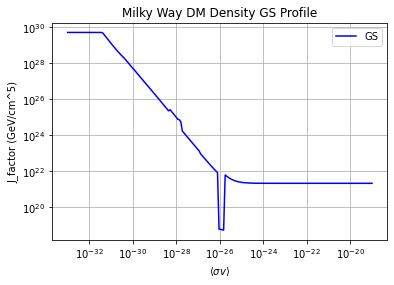

In [50]:
# Calculate J factors
plt.plot(sigma_v, J,label='GS', color='b')
plt.xlabel(r'$\langle \sigma v \rangle$')
plt.ylabel('J_factor (GeV/cm^5)')
plt.title('Milky Way DM Density GS Profile')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\RITABIK BANERJEE\AppData\Local\Temp\ipykernel_8052\4079117951.py:62: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result, error = quad(integrand,0, R+r0, args=(rs,r0, rhos, Rs, R_sat[i], Rsp, gamma_sp, rho_sat[i]))


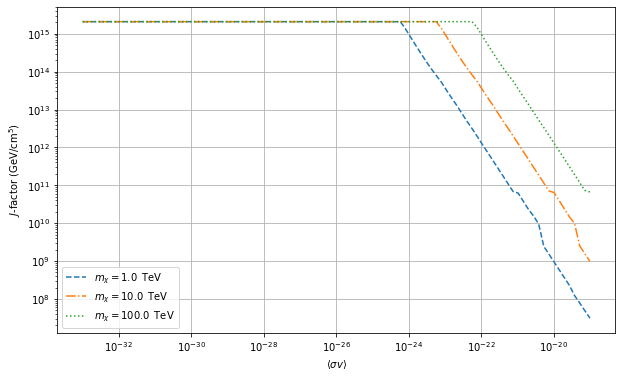

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad
from scipy.integrate import quad

# Function to calculate the NFW halo density profile
def nfw_halo(r, rs, rhos):
    x = r / rs
    return rhos / (x * (1 + x)**2)

# Function to calculate the Milky Way density profile based on Gondolo-Silk model
def mw_density_GS1(l,rs,r0, rhos, Rs, Rsat, Rsp, gamma_sp, rho_sat):
    r = np.abs(r0-l)
    
    if r < 2 * Rs:
        return 0
    elif 2 * Rs <= r < Rsat:
        return rho_sat * (r / Rsat) ** (-0.5)
    elif Rsat <= r < Rsp:
        x = r / Rsp
        return nfw_halo(Rsp, rs, rhos) * x**-gamma_sp
    else:
        return nfw_halo(r, rs, rhos)


rs = 18.6  # Scale radius in kpc
rho0 = 0.383  # Local DM density in GeV/cm^3
r0 = 8.2  # Sun position in kpc
m_chi_values = [1e3, 1e4, 1e5]  # Dark matter masses in GeV (1, 10, 100 TeV)
t = 3.15 * 10**17  # in s
rhos = rho0 * ((r0 / rs) * (1 + r0 / rs)**2)
R = 200  # Virial radius in kpc

# Parameters for the Milky Way density profile
Rs = 4.11 * 10**(-10)  # Example value for Rs in kpc
Rsp = 0.34 * 10**-3  # Example value for Rsp in kpc
gamma_sp = 2.35  # Example value for gamma_sp

sigma_v_values = np.logspace(-33, -19, 100)  # cm^3/s, annihilation cross-sections

# Calculate rho_sat and R_sat for each sigma_v
def calculate_rho_Rsat(m_chi,sigma_v_values):
    rho_sat = []
    R_sat = []
    for sigma_v in sigma_v_values:
        rho_sat_value = m_chi / (sigma_v * t)
        rho_sat.append(rho_sat_value)
        r_sat_value = (((rhos / rho_sat_value) * (rs / Rsp) * ((1 + (Rsp / rs))**-2))**(1 / gamma_sp)) * Rsp
        R_sat.append(r_sat_value)
    return rho_sat, R_sat

# Integrand for the J-factor
def integrand(l,rs,r0, rhos, Rs, R_sat, Rsp, gamma_sp, rho_sat):
    density = mw_density_GS1(l,rs,r0, rhos, Rs, R_sat, Rsp, gamma_sp, rho_sat)
    return density**2 *4 * np.pi

# Calculate J factors
def calculate_J_factors(m_chi):
    rho_sat, R_sat = calculate_rho_Rsat(m_chi)
    J_factors = []
    for i in range(len(sigma_v_values)):
        result, error = quad(integrand,0, R+r0, args=(rs,r0, rhos, Rs, R_sat[i], Rsp, gamma_sp, rho_sat[i]))
        J_factors.append(result)
    return J_factors

# Plotting
plt.figure(figsize=(10, 6))
linestyles = ['--', '-.', ':']
for i, m_chi in enumerate(m_chi_values):
    J_factors = calculate_J_factors(m_chi)
    plt.plot(sigma_v_values, J_factors, label=f'$m_\\chi = {m_chi / 1e3} \\,$ TeV', linestyle=linestyles[i])

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\langle \sigma v \rangle$')
plt.ylabel(r'$J$-factor (GeV/cm$^5$)')
plt.legend()
plt.grid(True)
plt.show()


In [456]:
import profiles as tp
from profiles import Constants as pc
from profiles import MWDensity as pm

In [457]:
a = pm(halo_types = ['NFW'],spike_types = ['GS'])

In [431]:
a.r = lambda l: np.abs(a.R_sun-l)

r = a.r

In [458]:
sigma_v =  np.logspace(-33,-19, 100)

In [459]:
R_sat,rho_sat=a.calculate_rho_sat_R_sat(1e3,sigma_v)

AttributeError: 'MWDensity' object has no attribute 'calculate_rho_sat_R_sat'

In [411]:


J = quad(a.calculate_density(R_sat[i], rho_sat[i],r)**2 * 4 * np.pi,0,a.R_sun+R)


AttributeError: 'MWDensity' object has no attribute 'calculate_density'